# Exercise 3: Mandatory Assignment
#B. Prediction Model

## Project Imports

In [0]:
import matplotlib.pyplot as plt
import matplotlib.font_manager
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib
import scipy as sp
import pylab as P
import random

from sklearn.neighbors import KNeighborsClassifier

# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# 1. Load the prepared training set

##  First run "!ls" command to check if it's already in the vm

In [58]:
!mkdir BAK
!cp *.csv BAK/
!rm *.csv
!ls

mkdir: cannot create directory ‘BAK’: File exists
BAK  datalab


## Download the train dataset from the cloud storage

In [0]:
downloaded = drive.CreateFile({'id': '1mwrxBXZsgHLFO9IpWYXNfUFJnLT5yraj'})
downloaded.GetContentFile('train_X.csv')

downloaded = drive.CreateFile({'id': '1FHPumn9bdXiLzO5tbpGGrcvxzNpoCG0Z'})
downloaded.GetContentFile('train_y.csv')

## we don't touch the Test-set until the end, so commented out.
#downloaded = drive.CreateFile({'id': '10F4pfym7OgqvT1xu6Bo27WqpZjsGhhih'})
#downloaded.GetContentFile('test_X.csv')

#downloaded = drive.CreateFile({'id': '1uGX6RQFot5gww3vExfpeg1GFR8ZMFYPX'})
#downloaded.GetContentFile('test_y.csv')

In [60]:
!ls

BAK  datalab  train_X.csv  train_y.csv


## Load the train set into dataframes (X, y)

In [0]:
train_X =      pd.read_csv("train_X.csv", header=0)
train_y =      pd.read_csv("train_y.csv", header=None)
#train_y.columns = ["Vote"]

# fix df_label as df_label[0] for easy writing..
train_y = train_y[0]

## View the loaded training set

In [62]:
train_X.info()
train_X.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5831 entries, 0 to 5830
Data columns (total 17 columns):
Number_of_valued_Kneset_members                  5831 non-null float64
Yearly_IncomeK                                   5831 non-null float64
Overall_happiness_score                          5831 non-null float64
Avg_Satisfaction_with_previous_vote              5831 non-null float64
Garden_sqr_meter_per_person_in_residancy_area    5831 non-null float64
Weighted_education_rank                          5831 non-null float64
Will_vote_only_large_party_1.0                   5831 non-null int64
Will_vote_only_large_party_0.0                   5831 non-null int64
Will_vote_only_large_party_2.0                   5831 non-null int64
Most_Important_Issue_4.0                         5831 non-null int64
Most_Important_Issue_1.0                         5831 non-null int64
Most_Important_Issue_7.0                         5831 non-null int64
Most_Important_Issue_5.0                         5831

,Number_of_valued_Kneset_members,Yearly_IncomeK,Overall_happiness_score,Avg_Satisfaction_with_previous_vote,Garden_sqr_meter_per_person_in_residancy_area,Weighted_education_rank,Will_vote_only_large_party_1.0,Will_vote_only_large_party_0.0,Will_vote_only_large_party_2.0,Most_Important_Issue_4.0,Most_Important_Issue_1.0,Most_Important_Issue_7.0,Most_Important_Issue_5.0,Most_Important_Issue_2.0,Most_Important_Issue_0.0,Most_Important_Issue_6.0,Most_Important_Issue_3.0
0,9.0,-1.135556,-4.210137,2.806640,-0.919437,3.395327,0,0,1,0,0,0,0,1,0,0,0
1,14.0,-0.674079,0.886686,1.802433,-0.102686,-0.133469,0,0,1,0,0,0,0,0,1,0,0
2,8.0,-0.965695,0.340745,-0.450976,0.477329,-0.416028,0,1,0,0,0,0,1,0,0,0,0
3,6.0,-0.093311,-0.093619,-0.650299,0.733155,-1.309064,1,0,0,0,0,0,0,1,0,0,0
4,6.0,2.259453,0.146151,0.304831,2.579338,0.818161,1,0,0,0,0,1,0,0,0,0,0


In [63]:
#train_y.info()
train_y.head(5)

0    0.0
1    0.0
2    4.0
3    1.0
4    5.0
Name: 0, dtype: float64

# 2. Train at least two models 

## Each training should be done via cross-validation on the training set, to maximize performance of the model while avoiding overfitting

### Utility Methods

In [0]:
def group_by_count(list):
  result = {}
  for item in list:
    if item in result:
      result[item] += 1
    else:
      result[item] = 1
  return result

In [0]:
import operator

def get_model_best_scoring_method(scores_dictionary):
  return max(scores_dictionary.iteritems(), key=operator.itemgetter(1))[0]
  
def get_model_best_score(scores_dictionary):
  return scores_dictionary[max(scores_dictionary.iteritems(), key=operator.itemgetter(1))[0]][0]

def get_model_best_configuration(scores_dictionary):
  return scores_dictionary[max(scores_dictionary.iteritems(), key=operator.itemgetter(1))[0]][1]

In [0]:
def show_model_results(model_name, scores_dictionary):
  model_best_score = get_model_best_score(scores_dict)
  model_best_config = get_model_best_configuration(scores_dict)
  model_best_scoring_method = get_model_best_scoring_method(scores_dict)
  
  print "Best scoring method: {0}".format(model_best_scoring_method)
  print "Max score for {0} classifier model: {1}".format(model_name, model_best_score)
  print "Model best configuration: {0}".format(model_best_config)
  
  return (model_best_score, model_best_config)

In [0]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# TODO: Notice - weighted is a form of macro which take to account for label imbalance
#scoring = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']
#scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted']
scoring = ['accuracy', 'precision_weighted']

def parameter_estimation_gridsearch_cv(X, y, estimator, tuned_parameters, k_fold=5):
  score_best_parameters = {}
  for score in scoring:
    print "# Tuning parameters for scoring method: {0}".format(score)
    print ""
    #clf = GridSearchCV(estimator, tuned_parameters, cv=k_fold, scoring=score)
    clf = GridSearchCV(estimator, tuned_parameters, cv=StratifiedKFold(n_splits=k_fold), scoring=score)
    clf.fit(X, y)
    print "Best parameters set found on development set: {0}, with score: {1}".format(clf.best_params_, clf.best_score_)
    print ""
    print "Grid scores on development set:"  
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
    print ""
    print "The model is trained on the development set."
    true_y, pred_y = y, clf.predict(X)
    print "The scores are computed on the evaluation set."    
    print ""
    print "Detailed classification report:"
    print ""    
    print classification_report(true_y, pred_y)
    print ""
    print "Detailed confusion matrix:"
    print ""
    clf_confusion_matrix = confusion_matrix(true_y, pred_y)
    print clf_confusion_matrix
    print ""
    score_best_parameters[score] = (clf.best_score_, clf.best_params_, clf_confusion_matrix)
  return score_best_parameters 

In [0]:
def plot_parameter_evaluation(x_label, y_label, x_values, y_values):
  plt.plot(x_values, y_values)
  plt.xlabel(x_label)
  plt.ylabel(y_label)

### Initialization

In [0]:
models_score_dictionary = {}
models_classifiers_dictionary = {}

## First Model: KNN - K Nearest Neighbors

### We'll optimize the model configuration using various scoring methods

In [0]:
from sklearn.neighbors import KNeighborsClassifier

tuned_parameters = {'n_neighbors': range(3, 15),
                    'algorithm': ['auto'],
                    'weights': ['uniform', 'distance']}

scores_dict = parameter_estimation_gridsearch_cv(train_X, train_y, KNeighborsClassifier(), tuned_parameters)

In [30]:
# Get best result for KNN
knn_best_score, knn_best_config = show_model_results("KNN", scores_dict)
models_score_dictionary["KNN"] = (knn_best_score, knn_best_config)

Max score for KNN classifier model: 0.926770708283
Model best configuration: {'n_neighbors': 4, 'weights': 'distance', 'algorithm': 'auto'}


### Now we'll fit the model with best configuration on the train set

In [71]:
from sklearn.neighbors import KNeighborsClassifier

# Instantiate model with best configuration
#knn = KNeighborsClassifier(n_neighbors=4, weights='distance', algorithm='auto')

# Instantiate model with default configuration
knn = KNeighborsClassifier()

models_classifiers_dictionary["KNN"] = knn

# Fit the model with train_X and train_y
knn.fit(train_X, train_y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

## Second Model: Multi-layer Perceptron    

### We'll optimize the model configuration using various scoring methods

In [19]:
from sklearn.neural_network import MLPClassifier

alpha_values = 10.0 ** -np.arange(1, 5)
"""
tuned_parameters = {'hidden_layer_sizes': [(100,), (13,), (17, 10,)],
                    'activation': ['logistic', 'tanh', 'relu'],
                    'alpha': alpha_values,
                    'learning_rate': ['constant', 'invscaling', 'adaptive']}
"""
tuned_parameters = {'hidden_layer_sizes': [(100,), (100, 17, 10,), (50, 25, 10,)],
                    'activation': ['relu'],
                    'alpha': alpha_values,
                    'learning_rate': ['constant', 'invscaling', 'adaptive']}

scores_dict = parameter_estimation_gridsearch_cv(train_X, train_y, MLPClassifier(), tuned_parameters)

# Tuning parameters for scoring method: accuracy

Best parameters set found on development set: {'alpha': 0.01, 'activation': 'relu', 'learning_rate': 'constant', 'hidden_layer_sizes': (100,)}, with score: 0.944606413994

Grid scores on development set:
0.937 (+/-0.014) for {'alpha': 0.10000000000000001, 'activation': 'relu', 'learning_rate': 'constant', 'hidden_layer_sizes': (100,)}
0.937 (+/-0.015) for {'alpha': 0.10000000000000001, 'activation': 'relu', 'learning_rate': 'invscaling', 'hidden_layer_sizes': (100,)}
0.937 (+/-0.012) for {'alpha': 0.10000000000000001, 'activation': 'relu', 'learning_rate': 'adaptive', 'hidden_layer_sizes': (100,)}
0.933 (+/-0.015) for {'alpha': 0.10000000000000001, 'activation': 'relu', 'learning_rate': 'constant', 'hidden_layer_sizes': (100, 17, 10)}
0.937 (+/-0.021) for {'alpha': 0.10000000000000001, 'activation': 'relu', 'learning_rate': 'invscaling', 'hidden_layer_sizes': (100, 17, 10)}
0.932 (+/-0.020) for {'alpha': 0.10000000000000001, 'activation

In [21]:
# Get best result for MLP
Perceptron_best_score, Perceptron_best_config = show_model_results("Perceptron", scores_dict)
models_score_dictionary["Perceptron"] = (Perceptron_best_score, Perceptron_best_config)

Best scoring method: precision_weighted
Max score for Perceptron classifier model: 0.944950957204
Model best configuration: {'alpha': 0.01, 'activation': 'relu', 'learning_rate': 'invscaling', 'hidden_layer_sizes': (100,)}


### Now we'll fit the model with best configuration on the train set

In [72]:
from sklearn.neural_network import MLPClassifier

# Instantiate model with best configuration
#perceptron = MLPClassifier(alpha=0.01, hidden_layer_sizes=(100, ), activation='relu', learning_rate="invscaling")

# Instantiate model with default configuration
perceptron = MLPClassifier()

models_classifiers_dictionary["Perceptron"] = perceptron

# Fit the model with train_X and train_y
perceptron.fit(train_X, train_y)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

## Third Model: Decision Tree

### We'll optimize the model configuration using various scoring methods

In [0]:
from sklearn.tree import DecisionTreeClassifier

max_depth = range(1, 16)
max_depth.append(None)

tuned_parameters = {'criterion': ['gini', 'entropy'],
                    'max_depth': max_depth}

scores_dict = parameter_estimation_gridsearch_cv(train_X, train_y, DecisionTreeClassifier(), tuned_parameters)

In [40]:
# Get best result for DecisionTree
tree_best_score, tree_best_config = show_model_results("DecisionTree", scores_dict)
models_score_dictionary["DecisionTree"] = (tree_best_score, tree_best_config)

Max score for DecisionTree classifier model: 0.937711081047
Model best configuration: {'criterion': 'gini', 'max_depth': 13}


### Now we'll fit the model with best configuration on the train set

In [73]:
from sklearn.tree import DecisionTreeClassifier

# Instantiate model with best configuration
#tree = DecisionTreeClassifier(criterion='gini', max_depth=13)

# Instantiate model with default configuration
tree = DecisionTreeClassifier()

models_classifiers_dictionary["DecisionTree"] = tree

# Fit the model with train_X and train_y
tree.fit(train_X, train_y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

## Forth Model: Linear SVC

### We'll optimize the model configuration using various scoring methods

In [0]:
from sklearn.svm import LinearSVC

C_start, C_end, C_step = -3, 10, 2
C_values = 2. ** np.arange(C_start, C_end + C_step, C_step)

tuned_parameters = {'penalty': ['l1', 'l2'],
                    'class_weight': [None, 'balanced'],
                    'dual': [False, True],
                    'C': C_values}

scores_dict = parameter_estimation_gridsearch_cv(train_X, train_y, LinearSVC(), tuned_parameters)

In [43]:
# Get best result for LinearSVC
svc_best_score, svc_best_config = show_model_results("SVC", scores_dict)
models_score_dictionary["SVC"] = (svc_best_score, svc_best_config)

Max score for SVC classifier model: 0.923771314891
Model best configuration: {'penalty': 'l2', 'C': 128.0, 'dual': False, 'class_weight': None}


### Now we'll fit the model with best configuration on the train set

In [74]:
from sklearn.svm import LinearSVC

# Instantiate model with best configuration
#svc = LinearSVC(penalty='l2', class_weight=None, C=128.0, dual=False)

# Instantiate model with default configuration
svc = LinearSVC()

models_classifiers_dictionary["SVC"] = svc

# Fit the model with train_X and train_y
svc.fit(train_X, train_y)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

# 3. Load the prepared valid set

## Download the train dataset from the cloud storage

In [0]:
downloaded = drive.CreateFile({'id': '1HgtZC1iq9VYH8Ygo6-6XnC6G0xa8Lz01'})
downloaded.GetContentFile('validation_X.csv')

downloaded = drive.CreateFile({'id': '1Z_0zOORoZJVlOQ58UdXml4maSNSNBBMK'})
downloaded.GetContentFile('validation_y.csv')

In [76]:
!ls

BAK  datalab  train_X.csv  train_y.csv	validation_X.csv  validation_y.csv


## Load the train set into dataframes (X, y)

In [0]:
valid_X =      pd.read_csv("validation_X.csv", header=0)
valid_y =      pd.read_csv("validation_y.csv", header=None)
# valid_y.columns = ["Vote"]

# fix df_label as df_label[0] for easy writing..
valid_y = valid_y[0]

## View the loaded training set

In [78]:
valid_X.info()
valid_X.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1944 entries, 0 to 1943
Data columns (total 17 columns):
Number_of_valued_Kneset_members                  1944 non-null float64
Yearly_IncomeK                                   1944 non-null float64
Overall_happiness_score                          1944 non-null float64
Avg_Satisfaction_with_previous_vote              1944 non-null float64
Garden_sqr_meter_per_person_in_residancy_area    1944 non-null float64
Weighted_education_rank                          1944 non-null float64
Will_vote_only_large_party_1.0                   1944 non-null int64
Will_vote_only_large_party_0.0                   1944 non-null int64
Will_vote_only_large_party_2.0                   1944 non-null int64
Most_Important_Issue_4.0                         1944 non-null int64
Most_Important_Issue_1.0                         1944 non-null int64
Most_Important_Issue_7.0                         1944 non-null int64
Most_Important_Issue_5.0                         1944

,Number_of_valued_Kneset_members,Yearly_IncomeK,Overall_happiness_score,Avg_Satisfaction_with_previous_vote,Garden_sqr_meter_per_person_in_residancy_area,Weighted_education_rank,Will_vote_only_large_party_1.0,Will_vote_only_large_party_0.0,Will_vote_only_large_party_2.0,Most_Important_Issue_4.0,Most_Important_Issue_1.0,Most_Important_Issue_7.0,Most_Important_Issue_5.0,Most_Important_Issue_2.0,Most_Important_Issue_0.0,Most_Important_Issue_6.0,Most_Important_Issue_3.0
0,12.0,-0.107043,-0.141038,0.691124,-0.480667,-0.275633,1,0,0,0,1,0,0,0,0,0,0
1,8.0,1.872975,-0.189318,-0.721718,1.867954,-0.110044,1,0,0,0,0,1,0,0,0,0,0
2,12.0,0.788380,1.631465,0.520939,-0.703350,0.511250,1,0,0,0,0,0,0,1,0,0,0
3,8.0,-0.098471,0.059599,0.688121,0.682170,-1.322242,1,0,0,1,0,0,0,0,0,0,0
4,9.0,-0.042849,0.565714,0.591769,-0.113672,-0.630451,1,0,0,0,0,1,0,0,0,0,0


In [79]:
valid_y.head(5)

0    6.0
1    5.0
2    2.0
3    8.0
4    6.0
Name: 0, dtype: float64

# 4. Apply the trained models on the valid set and check performance

## Utility methods

In [0]:
classes_names = ["0.0", "1.0", "2.0", "3.0", "4.0", "5.0", "6.0", "7.0", "8.0", "9.0"]

In [0]:
from sklearn.multiclass import OneVsRestClassifier

models_prediction_dictionary = {}
models_accuracy_dictionary = {}

def predict_model_labels(model_name, classifier, X, y):
  prediction = classifier.predict(X)
  prediction_label_count = group_by_count(prediction)
  for key, value in sorted(prediction_label_count.iteritems(), key=lambda (k,v): (v,k)):
    print "%s: %s" % (key, value)
  accuracy = classifier.score(valid_X, valid_y)
  print "{0} score: {1}".format(model_name, accuracy)
  models_accuracy_dictionary[model_name] = accuracy
  models_prediction_dictionary[model_name] = prediction
  return prediction

def get_model_decision_score(model, train_X, train_y, valid_X):
  # Learn to predict each class against the other
  classifier = OneVsRestClassifier(model)
  score_y = classifier.fit(train_X, train_y).decision_function(valid_X)
  return score_y

In [0]:
import itertools

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print title
    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title + " Plot")
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Predict labels using the trained model on the valid set

###KNN

In [93]:
knn_prediction = predict_model_labels("KNN", knn, valid_X, valid_y)

8.0: 44
9.0: 59
4.0: 96
3.0: 103
7.0: 126
0.0: 162
5.0: 192
2.0: 334
1.0: 414
6.0: 414
KNN score: 0.931069958848


###Multi-layer Perceptron

In [94]:
perceptron_prediction = predict_model_labels("Perceptron", perceptron, valid_X, valid_y)

9.0: 51
8.0: 56
3.0: 104
7.0: 105
4.0: 116
0.0: 181
5.0: 189
2.0: 327
1.0: 406
6.0: 409
Perceptron score: 0.942386831276


###DecisionTrees

In [95]:
tree_prediction = predict_model_labels("DecisionTree", tree, valid_X, valid_y)

8.0: 71
9.0: 71
4.0: 103
7.0: 110
3.0: 112
0.0: 161
5.0: 201
2.0: 324
1.0: 383
6.0: 408
DecisionTree score: 0.924382716049


### Linear SVC

In [96]:
svc_prediction = predict_model_labels("SVC", svc, valid_X, valid_y)

8.0: 36
9.0: 59
3.0: 104
7.0: 106
4.0: 115
5.0: 156
0.0: 171
2.0: 332
6.0: 423
1.0: 442
SVC score: 0.908436213992


## Performance measure (multiple measures)

###Receiver Operating Characteristic (ROC) (Multiclass implementation)

In [33]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# Binarize the output
valid_y_binary = label_binarize(valid_y, classes=[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0])
n_classes = valid_y_binary.shape[1]

# Learn to predict each class against the other
score_y = get_model_decision_score(perceptron, train_X, train_y, valid_X)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(valid_y[:, i], score_y[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(valid_y.ravel(), score_y.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

AttributeError: ignored

###Matthews correlation coefficient

In [34]:
from sklearn.metrics import matthews_corrcoef

print "Performance measure calculation using Matthews correlation coefficient:"
print "-----------------------------------------------------------------------"
for model_name, model_prediction in models_prediction_dictionary.iteritems():
  result = matthews_corrcoef(valid_y, model_prediction)
  print "{0} Matthews correlation coefficient result: {1}".format(model_name, result)

Performance measure calculation using Matthews correlation coefficient:
-----------------------------------------------------------------------


ValueError: ignored

###Accuracy classification score

In [50]:
from sklearn.metrics import accuracy_score

print "Performance measure calculation using Accuracy classification score:"
print "--------------------------------------------------------------------"
for model_name, model_prediction in models_prediction_dictionary.iteritems():
  result = accuracy_score(valid_y, model_prediction)
  print "{0} Accuracy classification score result: {1}".format(model_name, result)

Performance measure calculation using Accuracy classification score:
--------------------------------------------------------------------
KNN Accuracy classification score result: 0.931069958848
DecisionTree Accuracy classification score result: 0.921810699588
Perceptron Accuracy classification score result: 0.943930041152
SVC Accuracy classification score result: 0.908950617284


###Confusion Matrix

Performance measure calculation using Confusion Matrix:
-------------------------------------------------------
KNN Confusion Matrix
[[148   0   1   0   0   0   1   0   0  12]
 [  0 369   0   0   0   0   1   0   2   0]
 [  0   0 326   0   0   0   0   0   0   0]
 [  0   0   0  95   6   0   0   9   0   0]
 [  0   0   0   7  86   0   0  14   0   0]
 [  0  20   0   0   0 188   1   0   0   0]
 [  0   1   4   0   0   2 406   0   0   0]
 [  0   0   0   1   4   0   0 103   0   0]
 [  0  22   0   0   0   1   2   0  42   0]
 [ 14   2   3   0   0   1   3   0   0  47]]


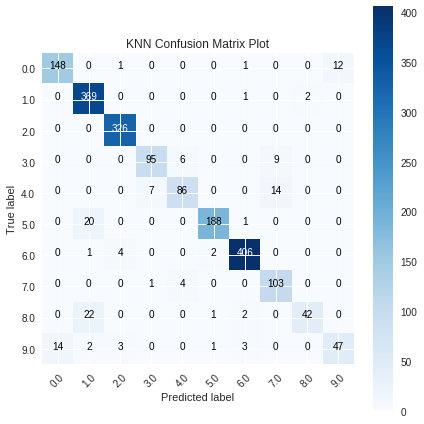

KNN Normalized Confusion Matrix
[[ 0.91  0.    0.01  0.    0.    0.    0.01  0.    0.    0.07]
 [ 0.    0.99  0.    0.    0.    0.    0.    0.    0.01  0.  ]
 [ 0.    0.    1.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.86  0.05  0.    0.    0.08  0.    0.  ]
 [ 0.    0.    0.    0.07  0.8   0.    0.    0.13  0.    0.  ]
 [ 0.    0.1   0.    0.    0.    0.9   0.    0.    0.    0.  ]
 [ 0.    0.    0.01  0.    0.    0.    0.98  0.    0.    0.  ]
 [ 0.    0.    0.    0.01  0.04  0.    0.    0.95  0.    0.  ]
 [ 0.    0.33  0.    0.    0.    0.01  0.03  0.    0.63  0.  ]
 [ 0.2   0.03  0.04  0.    0.    0.01  0.04  0.    0.    0.67]]


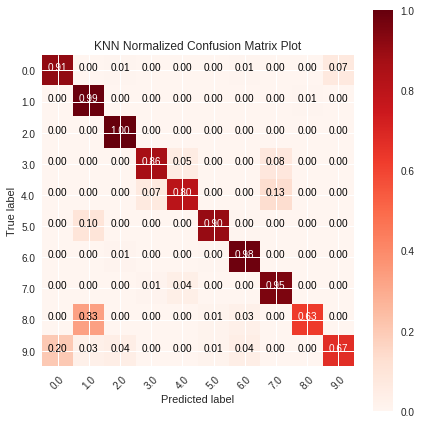

DecisionTree Confusion Matrix
[[149   0   0   0   0   0   0   0   0  13]
 [  0 340   0   0   0  12   7   0  13   0]
 [  0   0 323   0   0   0   2   0   1   0]
 [  0   0   0 108   2   0   0   0   0   0]
 [  0   0   0   4  98   0   0   5   0   0]
 [  0  22   0   0   0 177   7   0   3   0]
 [  0   6   1   0   0  11 390   0   5   0]
 [  0   0   0   0   3   0   0 105   0   0]
 [  0  15   0   0   0   1   2   0  49   0]
 [ 12   0   0   0   0   0   0   0   0  58]]


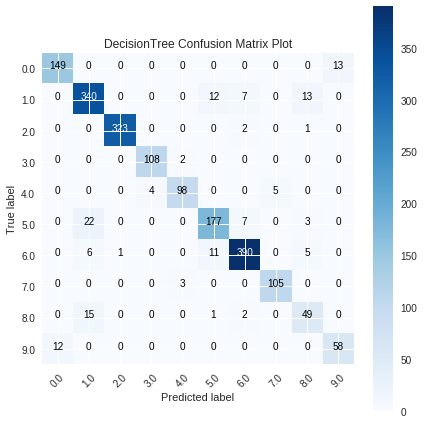

DecisionTree Normalized Confusion Matrix
[[ 0.92  0.    0.    0.    0.    0.    0.    0.    0.    0.08]
 [ 0.    0.91  0.    0.    0.    0.03  0.02  0.    0.03  0.  ]
 [ 0.    0.    0.99  0.    0.    0.    0.01  0.    0.    0.  ]
 [ 0.    0.    0.    0.98  0.02  0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.04  0.92  0.    0.    0.05  0.    0.  ]
 [ 0.    0.11  0.    0.    0.    0.85  0.03  0.    0.01  0.  ]
 [ 0.    0.01  0.    0.    0.    0.03  0.94  0.    0.01  0.  ]
 [ 0.    0.    0.    0.    0.03  0.    0.    0.97  0.    0.  ]
 [ 0.    0.22  0.    0.    0.    0.01  0.03  0.    0.73  0.  ]
 [ 0.17  0.    0.    0.    0.    0.    0.    0.    0.    0.83]]


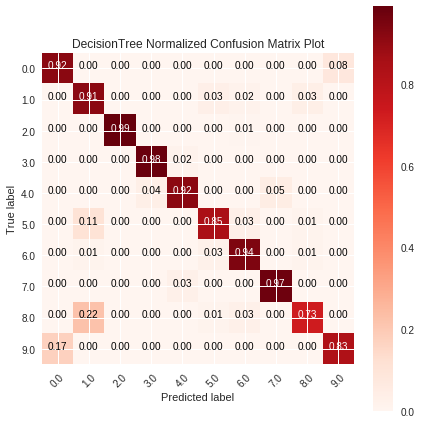

Perceptron Confusion Matrix
[[154   0   0   0   0   0   0   0   0   8]
 [  0 366   0   0   0   1   0   0   5   0]
 [  0   0 326   0   0   0   0   0   0   0]
 [  0   0   0  99   7   0   0   4   0   0]
 [  0   0   0   3 104   0   0   0   0   0]
 [  0  23   0   0   0 184   2   0   0   0]
 [  0   2   1   0   0   4 405   0   1   0]
 [  0   0   0   2   5   0   0 101   0   0]
 [  0  15   0   0   0   0   2   0  50   0]
 [ 27   0   0   0   0   0   0   0   0  43]]


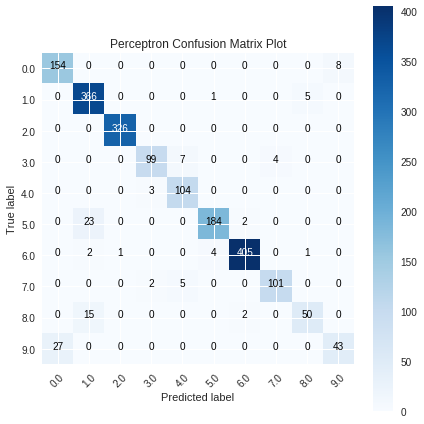

Perceptron Normalized Confusion Matrix
[[ 0.95  0.    0.    0.    0.    0.    0.    0.    0.    0.05]
 [ 0.    0.98  0.    0.    0.    0.    0.    0.    0.01  0.  ]
 [ 0.    0.    1.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.9   0.06  0.    0.    0.04  0.    0.  ]
 [ 0.    0.    0.    0.03  0.97  0.    0.    0.    0.    0.  ]
 [ 0.    0.11  0.    0.    0.    0.88  0.01  0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.01  0.98  0.    0.    0.  ]
 [ 0.    0.    0.    0.02  0.05  0.    0.    0.94  0.    0.  ]
 [ 0.    0.22  0.    0.    0.    0.    0.03  0.    0.75  0.  ]
 [ 0.39  0.    0.    0.    0.    0.    0.    0.    0.    0.61]]


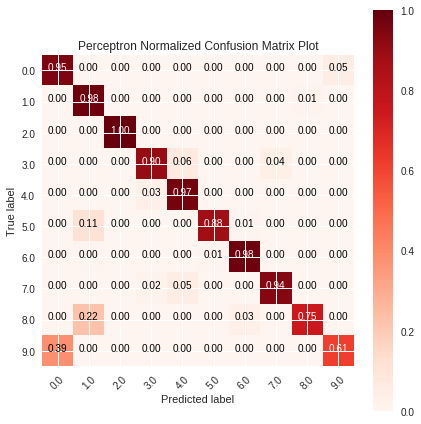

SVC Confusion Matrix
[[147   0   2   0   0   0   0   0   0  13]
 [  0 370   0   0   0   1   1   0   0   0]
 [  0   0 326   0   0   0   0   0   0   0]
 [  0   0   0  92   9   0   0   9   0   0]
 [  0   0   0   8  99   0   0   0   0   0]
 [  0  49   2   0   0 149   7   0   2   0]
 [  0   2   2   0   0   1 407   0   1   0]
 [  0   0   0   4   7   0   0  97   0   0]
 [  0  21   0   0   0   5   8   0  33   0]
 [ 24   0   0   0   0   0   0   0   0  46]]


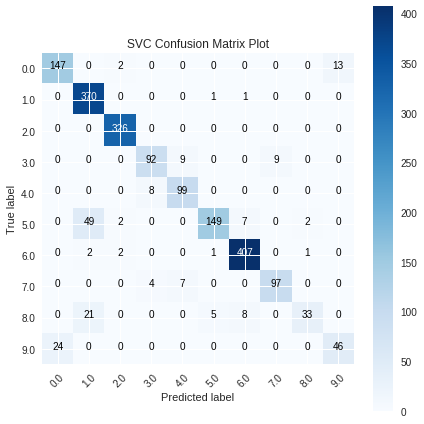

SVC Normalized Confusion Matrix
[[ 0.91  0.    0.01  0.    0.    0.    0.    0.    0.    0.08]
 [ 0.    0.99  0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    1.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.84  0.08  0.    0.    0.08  0.    0.  ]
 [ 0.    0.    0.    0.07  0.93  0.    0.    0.    0.    0.  ]
 [ 0.    0.23  0.01  0.    0.    0.71  0.03  0.    0.01  0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.99  0.    0.    0.  ]
 [ 0.    0.    0.    0.04  0.06  0.    0.    0.9   0.    0.  ]
 [ 0.    0.31  0.    0.    0.    0.07  0.12  0.    0.49  0.  ]
 [ 0.34  0.    0.    0.    0.    0.    0.    0.    0.    0.66]]


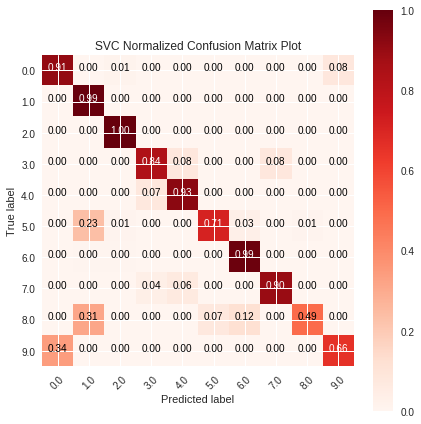

In [124]:
from sklearn.metrics import confusion_matrix

print "Performance measure calculation using Confusion Matrix:"
print "-------------------------------------------------------"
for model_name, model_prediction in models_prediction_dictionary.iteritems():  
  # Compute confusion matrix
  conf_matrix = confusion_matrix(valid_y, model_prediction)
  np.set_printoptions(precision=2)

  # Plot non-normalized confusion matrix
  plt.figure(figsize = (6,6))
  plot_confusion_matrix(conf_matrix, classes_names, False, "{0} Confusion Matrix".format(model_name), plt.cm.Blues)
  plt.show()

  # Plot normalized confusion matrix
  plt.figure(figsize = (6,6))
  plot_confusion_matrix(conf_matrix, classes_names, True, "{0} Normalized Confusion Matrix".format(model_name), plt.cm.Reds)
  plt.show()

###Classification Report

In [90]:
from sklearn.metrics import classification_report

print "Performance measure calculation using Classification Report:"
print "-------------------------------------------------------"
for model_name, model_prediction in models_prediction_dictionary.iteritems():
  class_report = classification_report(valid_y, model_prediction, target_names=classes_names)
  print "{0} Confusion Matrix".format(model_name)
  print class_report

Performance measure calculation using Classification Report:
-------------------------------------------------------
KNN Confusion Matrix
             precision    recall  f1-score   support

        0.0       0.91      0.91      0.91       162
        1.0       0.89      0.99      0.94       372
        2.0       0.98      1.00      0.99       326
        3.0       0.92      0.86      0.89       110
        4.0       0.90      0.80      0.85       107
        5.0       0.98      0.90      0.94       209
        6.0       0.98      0.98      0.98       413
        7.0       0.82      0.95      0.88       108
        8.0       0.95      0.63      0.76        67
        9.0       0.80      0.67      0.73        70

avg / total       0.93      0.93      0.93      1944

DecisionTree Confusion Matrix
             precision    recall  f1-score   support

        0.0       0.93      0.92      0.92       162
        1.0       0.89      0.91      0.90       372
        2.0       1.00      0.99 

# 5. Select the best model for the prediction tasks

## Manual selection of the model, based on the performance measurements

In [106]:
# As we can see in the performance measure of the trained models, we got that on the validation set the MLP (Multi-layer Perceptron) was the best model for out dataset.
# Therefore that model is the selected one for this Execise.

# Perceptron Accuracy classification score result: 0.942901234568
manual_selected_model = "Perceptron"
print manual_selected_model

Perceptron


## Automatic selection of the model, based on the performance measurements (Bonus)

In [107]:
import operator

best_model_by_accuracy = max(models_accuracy_dictionary.iteritems(), key=operator.itemgetter(1))[0]
automatic_selected_model = best_model_by_accuracy
print best_model_by_accuracy

Perceptron


# 6. Using the selected model to provide answers for the following questions

## Preperation

In [0]:
labels_dictionary = {0.0: "Blues",
                     1.0: "Browns",
                     2.0: "Greens",
                     3.0: "Greys",
                     4.0: "Oranges",
                     5.0: "Pinks",
                     6.0: "Purples",
                     7.0: "Reds",
                     8.0: "Whites",
                     9.0: "Yellows"}

labels = [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]
colors = ["blue", "brown", "green", "grey", "orange", "pink", "purple", "red", "white", "yellow"]

prediction_label_count = group_by_count(sorted(models_prediction_dictionary[manual_selected_model]))
prediction_values = prediction_label_count.values()

## Predict to which party each person in the valid set will vote (predict the label of each row in the valid set)

### Predict which party will win the majority of votes

In [109]:
winning_party = max(zip(prediction_label_count.values(), prediction_label_count.keys()))
print "The winning party is: {0} ({1}), with {2} votes.".format(labels_dictionary[winning_party[1]], winning_party[1], winning_party[0])

The winning party is: Purples (6.0), with 409 votes.


### Predict the division of voters between the various parties (the percentage of votes per party)

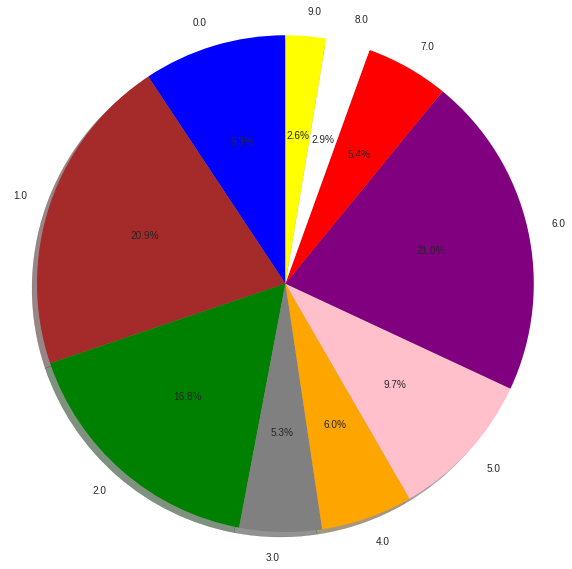

In [114]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
explode = (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)

fig1, ax1 = plt.subplots(figsize=(10,10))
ax1.pie(prediction_values, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

### On the Election Day, each party would like to suggest transportation services for its voters (Provide each party with a list of its most probable voters)

In [0]:
# Nothing to do ...

### Identify the factor (voters’ characteristic) which by manipulating you are most likely to change which party will win the election (Bonus)

Train dataset features importance:
----------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5831 entries, 0 to 5830
Data columns (total 17 columns):
Number_of_valued_Kneset_members                  5831 non-null float64
Yearly_IncomeK                                   5831 non-null float64
Overall_happiness_score                          5831 non-null float64
Avg_Satisfaction_with_previous_vote              5831 non-null float64
Garden_sqr_meter_per_person_in_residancy_area    5831 non-null float64
Weighted_education_rank                          5831 non-null float64
Will_vote_only_large_party_1.0                   5831 non-null int64
Will_vote_only_large_party_0.0                   5831 non-null int64
Will_vote_only_large_party_2.0                   5831 non-null int64
Most_Important_Issue_4.0                         5831 non-null int64
Most_Important_Issue_1.0                         5831 non-null int64
Most_Important_Issue_7.0                         583

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in divide


(5831, 17)
[ 0.53  0.84  0.92  0.4   1.    0.91  0.69  0.52  0.42  0.03  0.03  0.04
  0.17  0.03  0.03  0.17  0.15]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]


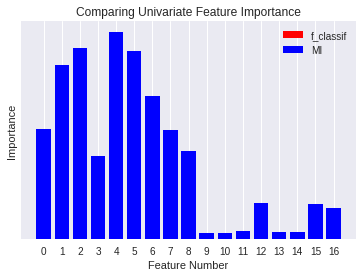


Valid dataset features importance:
----------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1944 entries, 0 to 1943
Data columns (total 17 columns):
Number_of_valued_Kneset_members                  1944 non-null float64
Yearly_IncomeK                                   1944 non-null float64
Overall_happiness_score                          1944 non-null float64
Avg_Satisfaction_with_previous_vote              1944 non-null float64
Garden_sqr_meter_per_person_in_residancy_area    1944 non-null float64
Weighted_education_rank                          1944 non-null float64
Will_vote_only_large_party_1.0                   1944 non-null int64
Will_vote_only_large_party_0.0                   1944 non-null int64
Will_vote_only_large_party_2.0                   1944 non-null int64
Most_Important_Issue_4.0                         1944 non-null int64
Most_Important_Issue_1.0                         1944 non-null int64
Most_Important_Issue_7.0                         19

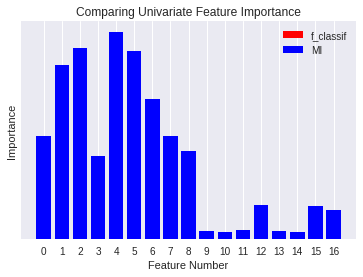

In [144]:
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import mutual_info_regression

def plot_feature_selection_comparision(X, classif_scores, MI_scores):
    X_indexes = np.arange(X.shape[-1])
    print X_indexes
    plt.bar(X_indexes, classif_scores, label="f_classif", color="r")
    plt.bar(X_indexes, MI_scores, label="MI", color="b")
    plt.title("Comparing Univariate Feature Importance")
    plt.xlabel('Feature Number')
    plt.ylabel('Importance')
    plt.xticks(range(0, X.shape[-1]))
    plt.yticks(())
    plt.legend(loc='upper right')
    plt.show()

def show_feature_importance(X, y):
  percentile = 100
  
  selector_classif = SelectPercentile(score_func=f_classif, percentile=0)
  selector_mi = SelectPercentile(score_func=mutual_info_classif, percentile=percentile)
  
  selector_classif.fit(train_X, train_y)
  classif_scores = selector_classif.scores_
  classif_scores /= classif_scores.max()
  classif_features_percent = selector_classif.transform(train_X)
  print classif_features_percent.shape
  print classif_scores
  
  selector_mi.fit(train_X, train_y)
  MI_scores = selector_mi.scores_
  MI_scores /= MI_scores.max()
  MI_features_percent = selector_mi.transform(train_X)
  print MI_features_percent.shape
  print MI_scores
  
  plot_feature_selection_comparision(train_X, classif_scores, MI_scores)
  
print "Train dataset features importance:"
print "----------------------------------"
print train_X.info()
show_feature_importance(train_X, train_y)

print ""
print "Valid dataset features importance:"
print "----------------------------------"
print valid_X.info()
show_feature_importance(valid_X, valid_y)

####***We can see in both datasets (Train, Valid) that the feature [Garden_sqr_meter_per_person_in_residancy_area] is the most significate feature in the data set which has the most MI to the label.***
####***Therefore by changing this value there is the most probabily that the label prediction will be different.***

## Construct the (valid) confusion matrix and overall test error

###Diff between True_Y and Pred_Y, display percentage and total number.

In [169]:
valid_X["Predicted_Vote"] = models_prediction_dictionary[manual_selected_model]
valid_X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1944 entries, 0 to 1943
Data columns (total 18 columns):
Number_of_valued_Kneset_members                  1944 non-null float64
Yearly_IncomeK                                   1944 non-null float64
Overall_happiness_score                          1944 non-null float64
Avg_Satisfaction_with_previous_vote              1944 non-null float64
Garden_sqr_meter_per_person_in_residancy_area    1944 non-null float64
Weighted_education_rank                          1944 non-null float64
Will_vote_only_large_party_1.0                   1944 non-null int64
Will_vote_only_large_party_0.0                   1944 non-null int64
Will_vote_only_large_party_2.0                   1944 non-null int64
Most_Important_Issue_4.0                         1944 non-null int64
Most_Important_Issue_1.0                         1944 non-null int64
Most_Important_Issue_7.0                         1944 non-null int64
Most_Important_Issue_5.0                         1944

In [166]:
# Calculate the difference between valid_y and predicted_y
dataset_size = len(valid_y)
print "Total dataset size: {0}".format(dataset_size)
matches = [i for i, j in zip(valid_y, models_prediction_dictionary[manual_selected_model]) if i == j]
matches_size = len(matches)
print "Matches count: {0}".format(matches_size)
print "Misses count: {0}".format(dataset_size - matches_size)
print "Algorithem (True Positive) accuracy: {0}%".format(float(100*float(matches_size)/float(dataset_size)))

Total dataset size: 1944
Matches count: 1832
Misses count: 112
Algorithem (True Positive) accuracy: 94.2386831276%


### Save validation dataset with Predicated Votes

In [0]:
valid_X.to_csv("Valid_X_with_Predicted_Vote.csv", index=False)

In [174]:
!ls

BAK	 train_X.csv  validation_X.csv	Valid_X_with_Predicted_Vote.csv
datalab  train_y.csv  validation_y.csv


In [0]:
from google.colab import files
files.download('Valid_X_with_Predicted_Vote.csv')

#References

##### http://scikit-learn.org/stable/tutorial/statistical_inference/model_selection.html
##### http://scikit-learn.org/stable/modules/model_evaluation.html - Best !
##### http://scikit-learn.org/stable/modules/cross_validation.html - Best !

##### http://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics - Best !
##### http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py - Best !
##### http://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html#sphx-glr-auto-examples-model-selection-plot-grid-search-digits-py
##### http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html#sklearn.model_selection.cross_val_score
##### http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html#sphx-glr-auto-examples-model-selection-plot-roc-crossval-py
##### http://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score
##### http://www.ritchieng.com/machine-learning-evaluate-classification-model/
##### http://www.ritchieng.com/machine-learning-efficiently-search-tuning-param/
##### http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#multiclass-settings

# NOTES

In [0]:
# HERE ARE THE DATA SETS TO DOWNLOAD FROM DRIVE:

#ElectionsData.csv
#https://drive.google.com/open?id=1Xdsqn2C0XR8AQnRfkWpU2JBQfK2rURe_

## NEW AFTER FIX -1:

#test_X.csv
#https://drive.google.com/open?id=10F4pfym7OgqvT1xu6Bo27WqpZjsGhhih

#test_y.csv
#https://drive.google.com/open?id=1uGX6RQFot5gww3vExfpeg1GFR8ZMFYPX

#train_X.csv
#https://drive.google.com/open?id=1mwrxBXZsgHLFO9IpWYXNfUFJnLT5yraj

#train_y.csv
#https://drive.google.com/open?id=1FHPumn9bdXiLzO5tbpGGrcvxzNpoCG0Z

#validation_X.csv
#https://drive.google.com/open?id=1HgtZC1iq9VYH8Ygo6-6XnC6G0xa8Lz01

#validation_y.csv
#https://drive.google.com/open?id=1Z_0zOORoZJVlOQ58UdXml4maSNSNBBMK